In [1]:
#!pip install vowpalwabbit

# Multi Armed Bandits
Multiarmed bandits are laerned on outputs of the first stage models: median predictions and quantiles forecasts.

In [74]:
from vowpalwabbit import pyvw
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [158]:
target, context = list(), list()
for i in range(46):
    try:
        target += [pd.read_csv(f'data/target/target_{i}.csv')]
        context += [(
            pd.read_csv(f'data/ngb/ngb_{i}.csv')
            .merge(pd.read_csv(f'data/qgb/qgb_{i}.csv'))
            .merge(pd.read_csv(f'data/qrf/qrf_{i}.csv'))
        )]
    except:
        pass
target = pd.concat(target)
context = pd.concat(context)

actions = ('-12','-9','-6','-3','-1','0','1','3','6','9','12','-100')

In [227]:
def get_cost(context, action, target, thresh = 0.1, helper=1, verbosity=-1):
    """
    Return cost QB try to maximize reward:
    in this setup MAB will try to find strategy that
    results in max overbidding.
    """
    # VW tries to minimize loss/cost, therefore we will pass COST as NEGATIVE reward
    if action == '-100':
        return 0.003  # no bid, lost time -0.3%
    else:
        prediction = (context['ngb_pred'] + context['QGB_50'] + context['QRF_50']) / 3
        bid = prediction * (100 + int(action)) / 100
        diff = ((bid - target) / target) * helper  # helper artificially reduces error
        if verbosity > 0:
            print(f"Action: {action}, difference {int(diff*100)}")
        
        if diff < 0:
            return 0.005  # if no win, lost time == -0.5%
        elif diff < thresh:
            return -0.025  # if overbid within thresh%, earn comission +2.5%
        else:
            return (diff - thresh)  # if overbid by more than thresh%, loss = - excess amount

In [169]:
context.iloc[idx,:].to_dict()

{'idx': '0000 1382 REVERE              AV000047610384761038312',
 'ngb_pred': 0.9310648754151254,
 'ngb_std': 0.1953512030887547,
 'QGB_10': 0.6520281120620668,
 'QGB_30': 0.741807843405273,
 'QGB_50': 0.8327522214612798,
 'QGB_70': 0.9437454141670392,
 'QGB_90': 1.1430557008260382,
 'QRF_10': 0.7088520940783037,
 'QRF_30': 0.7687423351033933,
 'QRF_50': 0.853582093179226,
 'QRF_70': 1.020220027162755,
 'QRF_90': 1.3033302142620018}

In [110]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
        
    # example_string = ""
    # example_string += f"shared |User f1={context['f1']} f2={context['f2']} f3={context['f3']} f4={context['f4']}\n"
    
    example_string = f"shared |User "
    for k in context.keys():
        if k != 'idx':
            example_string += f"{k}={context[k]} "
    example_string = example_string[:-1] + '\n'
    
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
            
        example_string += "|Action article={} \n".format(action)
        
    #Strip the last newline
    return example_string[:-1]

In [111]:
to_vw_example_format(ctx, actions, cb_label = None)

'shared |User ngb_pred=0.9310648754151254 ngb_std=0.1953512030887547 QGB_10=0.6520281120620668 QGB_30=0.741807843405273 QGB_50=0.8327522214612798 QGB_70=0.9437454141670392 QGB_90=1.1430557008260382 QRF_10=0.7088520940783037 QRF_30=0.7687423351033933 QRF_50=0.853582093179226 QRF_70=1.020220027162755 QRF_90=1.3033302142620018\n|Action article=-12 \n|Action article=-9 \n|Action article=-6 \n|Action article=-3 \n|Action article=0 \n|Action article=3 \n|Action article=6 \n|Action article=9 \n|Action article=12 \n|Action article=-100 '

In [112]:
def sample_custom_pmf(pmf):
    
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [113]:
def get_action(vw, context, actions):
    
    vw_text_example = to_vw_example_format(context, actions)
    
    pmf = vw.predict(vw_text_example)
    
    chosen_action_index, prob = sample_custom_pmf(pmf)
    
    return actions[chosen_action_index], prob

In [233]:
def run_simulation(
    vw,
    context,
    target,
    actions,
    cost_function,
    helper,
    do_learn = True
):
    cost_sum = 0.
    ctr, actions_list = list(), list()

    for i in range(len(target)):
        ctx = context.iloc[i, :].to_dict()
        action, prob = get_action(vw, ctx, actions)  # get action

        # 4. Get cost of the action we chose
        cost = cost_function(ctx, action, target.iloc[i, 1], helper=helper)  # calulate cost
        cost_sum += (-cost)  # add cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            # print(to_vw_example_format(ctx, actions, (action, cost, prob)))
            vw_format = vw.parse(
                to_vw_example_format(ctx, actions, (action, cost, prob)),
                pyvw.vw.lContextualBandit
            )
            
            # 6. Learn
            vw.learn(vw_format)
            
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-cost)
        actions_list.append(action)
        
    return ctr, actions_list

## MABs trainings:
The predictions of the first stage models are not accurate enough, so MABs refrain from bidding in order to maximize earnings (minimizing loss). To show that MABs are capable of maximizing profits, we use 'helper' parameter to scale down predictions error and examine MAB performance with the improved predicitons.

We find that MAPE has to be decreased by 70% in order for the MABs to find a profitable strategy. Moveover, we observe that MABs successfully use provided features to adjust the bid in order to maximize the profits. 

We will present the analysis of the result in the presentation.

In [232]:
# Instantiate learner in VW

for helper in [0.1, 0.2, 0.3, 0.4, 0.5, 1]:
    vw = pyvw.vw("--cb_explore_adf -q UA  --epsilon 0.1")
    ctr, actions_list = run_simulation(vw, context, target, actions, get_cost, helper)
    print(np.mean(ctr))
    
#plot_ctr(num_iterations, ctr)

0.015212627272569213
0.009390423458021479
0.0035940365279460776
-0.002832368695412256
-0.00345263601136319
-0.006988279258911315


In [234]:
target.shape

(16798, 2)

<AxesSubplot:ylabel='Frequency'>

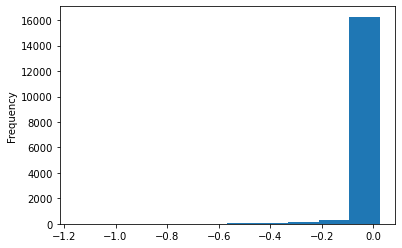

In [230]:
# MABs refreain from bidding with the deafult predictions:
pd.Series(ctr).plot.hist()